<Axes: >

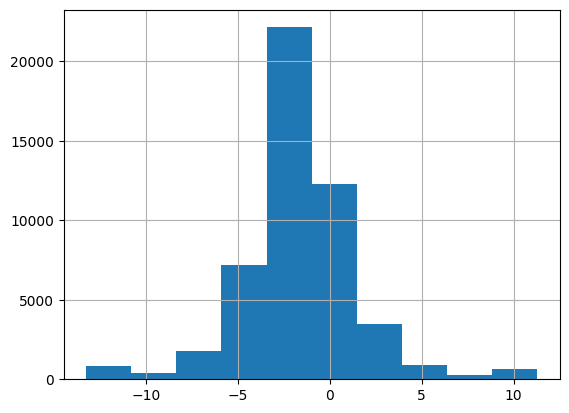

In [481]:
import json
import numpy as np
import pandas as pd
from finroberta.finroberta_model import FinRobertaTokenizer

tokenizer = FinRobertaTokenizer("../dicts_and_tokenizers/finroberta_tokenizer.json")

with open("../dicts_and_tokenizers/token_counts_finance_corpus.json", "r") as jf:
    finance_counts = json.load(jf)

with open("../dicts_and_tokenizers/token_counts_wiki_corpus.json", "r") as jf:
    wiki_counts = json.load(jf)

counts = pd.concat((pd.Series(finance_counts), pd.Series(wiki_counts)), axis=1)
counts.columns = ["finance", "wiki"]
counts.index = [int(idx) for idx in  counts.index]
counts.loc[:4, ["finance", "wiki"]] = [[0, 0]] * 5
freqs = counts / counts.sum()

not_occuring = freqs[(freqs.finance == 0) & (freqs.wiki == 0)].copy()
only_finance = freqs[(freqs.finance != 0) & (freqs.wiki == 0)].copy()
only_wiki = freqs[(freqs.finance == 0) & (freqs.wiki != 0)].copy()
finance_and_wiki = freqs[(freqs.finance != 0) & (freqs.wiki != 0)].copy()

finance_and_wiki.loc[:, "finance_score"] = (finance_and_wiki.finance / finance_and_wiki.wiki).apply(np.log)
lower_score = finance_and_wiki.finance_score.min()
upper_score = finance_and_wiki.finance_score.max()

only_finance.loc[:, "finance_score"] = upper_score
only_wiki.loc[:, "finance_score"] = lower_score
not_occuring.loc[:, "finance_score"] = lower_score - 1

financial_mask_scores = pd.concat((finance_and_wiki, only_wiki, only_finance, not_occuring)).sort_index()
financial_mask_scores.drop(["finance", "wiki"], axis = 1, inplace = True)
financial_mask_scores.finance_score.hist()

In [635]:
#financial_mask_scores.reset_index(drop = False).rename({"index": "token_id"}, axis = 1).to_csv("../dicts_and_tokenizers/financial_mask_scores.csv", index = False)

In [468]:
for idx in financial_mask_scores.sort_values(by = "finance_score", ascending=False).iloc[500:600].index:
    print(tokenizer.convert_ids_to_tokens(int(idx)))

Ġreimbur
Ġ________________________________________________
ustreasurys
availablefor
substandardmember
eloansmember
itiesmember
otherassetsmember
cilingitemsmember
estimateoffairvaluefairvaluedisclosuremember
airvalue
includingportion
Ġcarryfor
Ġ$(,
ensemember
corporatedebtsecuritiesmember
Ġ__________
employeestockoptionmember
interestmember
foreignplanmember
accountsreceivablemember
sandiegogas
egmentmember
shortdurationinsurancecontractsaccidentyearmember
accumulatedgainlossnetcashflowhedge
sharebasedcompensationaward
geographicconcentrationriskmember
interestrat
Ġ________________________
Ġafudc
qualifiedplanmember
esignatedmember
nondesignatedmember
eliminationsmember
Ġ______
operationsmember
revolvingcreditfacilitymember
heldforsal
backedsecuritiesmember
stateandlocal
receivablesmember
forecastmember
optionmember
offairvalue
ï¿½ï¿½ï¿½ï¿½
businessmember
feesmember
accumulatedgainlossnet
Ġ______________
accumulatednetgainlossfromdesignatedorqualifyingcashflowhedgesmember
wapmember
lea

In [449]:
for idx in financial_mask_scores.sort_values(by = "finance_score", ascending=True).iloc[:100].index:
    print(tokenizer.convert_ids_to_tokens(int(idx)))

<s>
estimateoffairvalue
).',
?',
reportedamount
carryingreportedamount
Ð
exelong
Ġbazadebez
Ġbazadebezolkohpep
ĭáħ
<pad>
<unk>
Ġ-).*
</s>
<mask>
¿½
ÏģÎ¹
emoration
Ø³
Ġprostitute
ocese
Ø§Ù
Ġtortricidae
Ġsportspeople
telugu
ãĢĭ
ĠÐ
sportspeople
|âĢĵ
Ġcrambidae
ãĥ³
Ġupaz
ĊĊĠĊĠĊ
wikitable
Ġmagdal
ĠĊ
Ġ#âĢĵ
áħ¢
Ġsuffragan
Ð°Ñı
Ġ(Â
ãģ®
lepidoptera
Ġsaxophonists
Ġepigraph
ĠÐº
à®
ĠĊĊĠĊĊ
Ġ}}
Ġarchdeacon
à¤®
ÑĬ
fiba
ricidae
racehorses
Ġeastenders
erbahce
ostoma
ĠÐ¸
Ġdefenceman
Ġbajn
bernatorial
ĠĊĊĠ
Î¼
ellidae
Ð¾Ðº
Ñĸ
à¤
Ġgeographer
Ġ(âĢĵ):
âĢĵ:
Ġ(âĨĴ
Ġsofla
Ġepiscop
bangladeshi
ÐµÑĤ
Ġpolbot
bgcolor
Ġvedic
Ġreichstag
filmography
Ġvenerated
áĦĭáħµ
ĠØ
ikovsky
Ġgoalk
Ġpasseriformesfamily
Ġprostitut
footballer
Ġgoalscorers
ĠÏĦ
segunda
ÉĻ
ibery
åŃ¦æł¡
ãĥı
Ð±
ãĢĬ
ffbb


In [585]:
import sqlite3
import torch 


def financial_masks(input_id_list: list[int], attention_mask_list: list[int], low_mask_pd: float = 0.025, high_mask_pd: float = 0.275) -> list[float]:
    seq_len = np.sum(attention_mask_list)
    mask_identifier = financial_mask_scores.loc[input_id_list].rank() < (seq_len / 2)
    return mask_identifier.apply(lambda x: x * low_mask_pd + (1 - x) * high_mask_pd).values.flatten().tolist()

financial_masking = True

conn = sqlite3.connect("/Users/ralfkellner/Data/Textdata/FinRobertaTextsProcessed.sqlite")
curs = conn.cursor()
curs.execute("SELECT * FROM k_report_sequences LIMIT 320000;")
labeled_ids_overall = []
while True:
    rows = curs.fetchmany(32)
    if not(rows):
        break
    # masking
    # regular masking
    if not(financial_masking):
        lines = [element[0]for element in rows]
        inputs = tokenizer(lines, padding="max_length", max_length=252, truncation=True, return_tensors = "pt")
        inputs["labels"] = inputs.input_ids.clone()
        rand = torch.rand(inputs['input_ids'].shape)
        mask_arr = (rand < 0.15) * (inputs['input_ids'] != 0) * (inputs['input_ids'] != 1) * (inputs['input_ids'] != 2) * (inputs['input_ids'] != 3)
        labeled_ids = inputs['input_ids'][mask_arr]
        labeled_ids_overall.extend(labeled_ids.tolist())
        inputs['input_ids'][mask_arr] = 4
    #financial masking
    else:
        lines = [element[0]for element in rows]
        inputs_raw = tokenizer(lines, padding="max_length", max_length=252, truncation=True)
        inputs_pt = tokenizer(lines, padding="max_length", max_length=252, truncation=True, return_tensors = "pt")

        mask = torch.Tensor(list(map(financial_masks, inputs_raw.input_ids, inputs_raw.attention_mask)))
        rand = torch.rand(mask.shape)
        mask_arr = rand < mask * (inputs_pt['input_ids'] != 0) * (inputs_pt['input_ids'] != 1) * (inputs_pt['input_ids'] != 2) * (inputs_pt['input_ids'] != 3)

        inputs_pt["labels"] = inputs_pt.input_ids.clone()
        labeled_ids = inputs_pt['input_ids'][mask_arr]
        labeled_ids_overall.extend(labeled_ids.tolist())
        inputs_pt['input_ids'][mask_arr] = 4

curs.close()
conn.close()

In [586]:
labeled_ids_overall_financial_mask = labeled_ids_overall.copy()

In [560]:
labeled_ids_overall_regular_mask = labeled_ids_overall.copy()

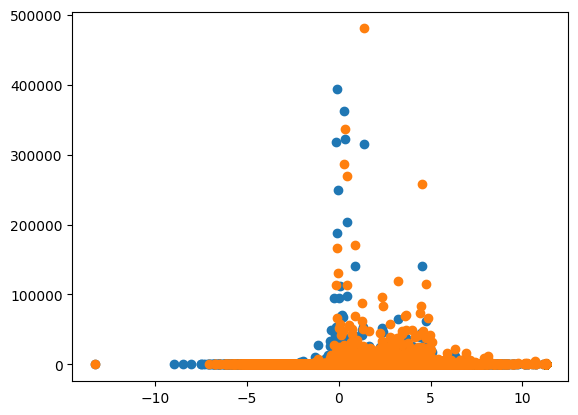

In [589]:
import matplotlib.pylab as plt

regular_mask_counts_ids, regular_mask_counts = np.unique(labeled_ids_overall_regular_mask, return_counts=True)
financial_mask_counts_ids, financial_mask_counts = np.unique(labeled_ids_overall_financial_mask, return_counts=True)
plt.scatter(financial_mask_scores.loc[regular_mask_counts_ids.tolist()].values.flatten(), regular_mask_counts)
plt.scatter(financial_mask_scores.loc[financial_mask_counts_ids.tolist()].values.flatten(), financial_mask_counts)

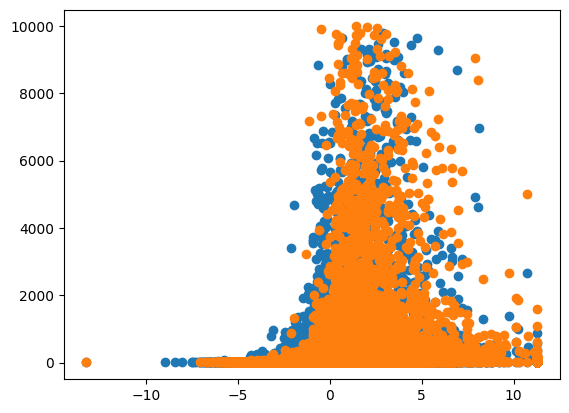

In [627]:
import matplotlib.pylab as plt


max_count = 10000
regular_mask_counts_ids, regular_mask_counts = np.unique(labeled_ids_overall_regular_mask, return_counts=True)
financial_mask_counts_ids, financial_mask_counts = np.unique(labeled_ids_overall_financial_mask, return_counts=True)
plt.scatter(financial_mask_scores.loc[regular_mask_counts_ids[regular_mask_counts <= max_count].tolist()].values.flatten(), regular_mask_counts[regular_mask_counts <= max_count])
plt.scatter(financial_mask_scores.loc[financial_mask_counts_ids[financial_mask_counts <= max_count].tolist()].values.flatten(), financial_mask_counts[financial_mask_counts <= max_count])

In [ ]:
plt.scatter(financial_mask_scores.loc[financial_mask_counts_ids.tolist()].values.flatten(), financial_mask_counts)

In [614]:
top10_regular = regular_mask_counts_ids[np.flip(regular_mask_counts.argsort())[50:100]]
for id in top10_regular:
    print(tokenizer.convert_ids_to_tokens(int(id)))

Ġtotal
Ġan
Ġvalue
Ġcash
Ġconsolidated
Ġoperations
Ġ,,
Ġits
Ġstatements
Ġfiscal
s
Ġnot
Ġended
Ġwere
Ġinterest
Ġhave
Ġrelated
Ġyears
Ġmay
Ġbusiness
Ġunder
Ġsales
Ġoperating
Ġsecurities
Ġrate
Ġcosts
Ġplan
Ġdue
Ġtable
Ġfair
Ġshare
Ġthis
Ġcredit
;
Ġcommon
Ġnotes
a
Ġ()
Ġapproximately
Ġequity
Ġshares
Ġ(,
Ġ.%
Ġexpense
Ġcertain
Ġcost
Ġper
Ġu
Ġform
Ġhas


In [613]:
top10_financial = financial_mask_counts_ids[np.flip(financial_mask_counts.argsort())[50:100]]
for id in top10_financial:
    print(tokenizer.convert_ids_to_tokens(int(id)))

Ġbusiness
Ġsales
Ġnot
Ġmay
Ġsecurities
Ġoperating
Ġunder
Ġrate
Ġcosts
Ġtable
Ġplan
Ġfair
Ġa
Ġshare
Ġwhich
Ġcredit
Ġdue
Ġnotes
Ġyears
Ġcommon
Ġequity
Ġapproximately
Ġshares
Ġwith
Ġcertain
Ġexpense
Ġcost
Ġform
Ġthis
Ġ(,
Ġdebt
Ġwill
Ġ$,
Ġreport
Ġthese
Ġits
Ġliabilities
Ġinformation
Ġper
Ġproducts
Ġrespectively
:
Ġmarket
Ġincrease
Ġinc
Ġloss
Ġcapital
Ġaccounting
we
Ġagreement


In [617]:
financial_mask_counts_ids[np.flip(financial_mask_counts.argsort())[50:100]]

array([ 517,  753,  341,  427,  747,  727,  488,  813,  749, 1008,  769,
        752,  177,  663,  405,  837,  826,  918,  638,  615,  922,  956,
        690,  287,  736,  970,  525,  607,  440,  730, 1011,  497,  670,
        541,  544,  492, 1006,  861,  357,  750, 1272,   20,  570,  913,
        271,  669,  711,  890,  805,  802])

<BarContainer object of 50 artists>

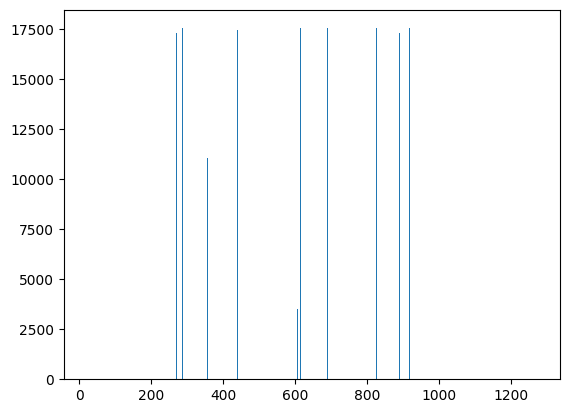

In [619]:
plt.bar(financial_mask_counts_ids[np.flip(financial_mask_counts.argsort())[50:100]].tolist(), financial_mask_counts.argsort()[50:100])

In [590]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(x: 'float | ArrayLike', height: 'float | ArrayLike', width: 'float | ArrayLike' = 0.8, bottom: 'float | ArrayLike | None' = None, *, align: "Literal['center', 'edge']" = 'center', data=None, **kwargs) -> 'BarContainer'
    Make a bar plot.
    
    The bars are positioned at *x* with the given *align*\ment. Their
    dimensions are given by *height* and *width*. The vertical baseline
    is *bottom* (default 0).
    
    Many parameters can take either a single value applying to all bars
    or a sequence of values, one for each bar.
    
    Parameters
    ----------
    x : float or array-like
        The x coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    height : float or array-like
        The height(s) of the bars.
    
        Note that if *bottom* has units (e.g. datetime), *height* should be in
        units that are a difference from the value of *bottom* (e.g. ti

In [540]:


lines = [element[0]for element in rows]
inputs_raw = tokenizer(lines, padding="max_length", max_length=252, truncation=True)
inputs_pt = tokenizer(lines, padding="max_length", max_length=252, truncation=True, return_tensors = "pt")

mask = torch.Tensor(list(map(financial_masks, inputs_raw.input_ids, inputs_raw.attention_mask)))
rand = torch.rand(mask.shape)
mask_arr = rand < mask * (inputs_pt['input_ids'] != 0) * (inputs_pt['input_ids'] != 1) * (inputs_pt['input_ids'] != 2) * (inputs_pt['input_ids'] != 3)

inputs_pt["labels"] = inputs_pt.input_ids.clone()
labeled_ids = inputs_pt['input_ids'][mask_arr]
inputs_pt['input_ids'][mask_arr] = 4
mask_arr.sum(axis = 1)

tensor([41, 32, 34, 41, 37])

In [541]:
labeled_ids

tensor([15086,  1464,  3232,   541,   213,  1591,   200,   237,   223,   273,
         3328,   213,    13,   747,   453,  3328,  1760,  2494, 10217,  4559,
          273,    18,   223,  1367,  3988,  1726,   340,  2688,  2445,    12,
          905,   405,   988,  1092,  1591,   453,   829,   494,  1534,  1591,
          273, 21855,   494,  1293,  1047,  1591,    13,   747,   453,  1673,
         1534,  1047,   494,  2977,  1839,   259,  3784,  1062,  1196,    18,
        10074,   444,  2519,  1092,  3622,  7078,   345,  3328,   273,  1862,
          200,  1092,   453,  1839, 10413,   890,   273,  1839,   345,  2519,
          577,   200,   269,   412,   615,   438,   223,  1717,  1169,  3259,
         1037,    16,   213,  3014,   541,  1464,  1008,   538,   910,   517,
          910,   717,  3084,   261,  7967,  2209,   422, 41034,   206,  1052,
          261,   261,   422,  2159,  2081, 20563,   261,   717, 19579,  1623,
          261,   910,   261,  3153,   538,   910,  1492,  3799, 

In [527]:
import torch

mask = torch.Tensor(list(map(financial_masks, inputs_raw.input_ids, inputs_raw.attention_mask)))
rand = torch.rand(mask.shape)
mask_arr = rand < mask * (inputs_pt['input_ids'] != 0) * (inputs_pt['input_ids'] != 1) * (inputs_pt['input_ids'] != 2) * (inputs_pt['input_ids'] != 3)

inputs_pt["labels"] = inputs_pt.input_ids.clone()
inputs_pt['input_ids'][mask_arr] = 4

In [528]:
inputs_pt

{'input_ids': tensor([[    0, 15086,   200,  ...,     1,     1,     1],
        [    0, 21855,   494,  ...,     1,     1,     1],
        [    0,  1001, 12734,  ...,     1,     1,     1],
        [    0, 41034,   206,  ...,     1,     1,     1],
        [    0,   484,     4,  ...,    18,     3,     1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0]]), 'labels': tensor([[    0, 15086,   200,  ...,     1,     1,     1],
        [    0, 21855,   494,  ...,     1,     1,     1],
        [    0,  1001, 12734,  ...,     1,     1,     1],
        [    0, 41034,   206,  ...,     1,     1,     1],
        [    0,   484,   753,  ...,    18,     3,     1]])}

In [503]:
financial_masks(input_id_list=inputs.input_ids[0], attention_mask_list = inputs.attention_mask[0])

[0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.05,
 0.25,
 0.25,
 0.25,
 0.25,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.25,
 0.25,
 0.25,
 0.05,
 0.25,
 0.05,
 0.05,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.25,
 0.25,
 0.25,
 0.05,
 0.25,
 0.05,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.25,
 0.25,
 0.25,
 0.05,
 0.25,
 0.05,
 0.25,
 0.25,
 0.05,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.05,
 0.25,
 0.25,
 0.25,
 0.05,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.05,
 0.25,
 0.25,
 0.25,
 0.05,
 0.25,
 0.25,
 0.05,
 0.05,
 0.25,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.25,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.25,
 0.05,
 0.05,
 0.25,
 0.05,
 0.05,
 0.25,
 0.05,
 0.25,
 0.25,
 0.25,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.25,
 0.25,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.05,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,

In [497]:
mask_identifier.apply(lambda x: x * 0.05 + (1 - x) * 0.25).values.flatten().tolist()

[0.05,
 0.05,
 0.05,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.05,
 0.25,
 0.05,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.05,
 0.25,
 0.05,
 0.05,
 0.25,
 0.25,
 0.05,
 0.25,
 0.25,
 0.25,
 0.25,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.25,
 0.05,
 0.25,
 0.25,
 0.05,
 0.25,
 0.05,
 0.05,
 0.05,
 0.05,
 0.25,
 0.05,
 0.05,
 0.05,
 0.05,
 0.25,
 0.05,
 0.25,
 0.25,
 0.05,
 0.25,
 0.25,
 0.25,
 0.05,
 0.25,
 0.25,
 0.05,
 0.05,
 0.05,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.05,
 0.05,
 0.25,
 0.05,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.05,
 0.05,
 0.05,
 0.25,
 0.25,
 0.05,
 0.25,
 0.25,
 0.05,
 0.25,
 0.25,
 0.25,
 0.05,
 0.05,
 0.25,
 0.05,
 0.25,
 0.25,
 0.05,
 0.05,
 0.25,
 0.05,
 0.25,
 0.25,
 0.25,
 0.25,
 0.05,
 0.25,
 0.25,
 0.05,
 0.25,
 0.25,
 0.05,
 0.05,
 0.25,
 0.25,
 0.05,
 0.05,
 0.25,
 0.05,
 0.25,
 0.05,
 0.05,
 0.05,
 0.05,
 0.25,
 0.25,
 0.05,
 0.05,
 0.05,
 0.25,
 0.25,
 0.05,
 0.05,
 0.25,
 0.25,
 0.05,
 0.25,
 0.25,
 0.25,

In [465]:
mask_identifier = financial_mask_scores.loc[inputs.input_ids].rank() < (len(inputs.input_ids)/2)
mask_identifier.apply(lambda x: x * 0.25 + (1 - x) * 0.05)#.apply(lambda x: 0.25 if x else 0.05)

,finance_score
0,0.25
1001,0.25
12734,0.25
299,0.25
2977,0.05
...,...
619,0.05
910,0.05
177,0.25
18,0.25


In [453]:
help(financial_mask_scores.loc[inputs.input_ids].rank)

Help on method rank in module pandas.core.generic:

rank(axis: 'Axis' = 0, method: "Literal['average', 'min', 'max', 'first', 'dense']" = 'average', numeric_only: 'bool_t' = False, na_option: "Literal['keep', 'top', 'bottom']" = 'keep', ascending: 'bool_t' = True, pct: 'bool_t' = False) -> 'Self' method of pandas.core.frame.DataFrame instance
    Compute numerical data ranks (1 through n) along axis.
    
    By default, equal values are assigned a rank that is the average of the
    ranks of those values.
    
    Parameters
    ----------
    axis : {0 or 'index', 1 or 'columns'}, default 0
        Index to direct ranking.
        For `Series` this parameter is unused and defaults to 0.
    method : {'average', 'min', 'max', 'first', 'dense'}, default 'average'
        How to rank the group of records that have the same value (i.e. ties):
    
        * average: average rank of the group
        * min: lowest rank in the group
        * max: highest rank in the group
        * first:

In [444]:
inputs.input_ids

[0,
 1001,
 12734,
 299,
 2977,
 475,
 1839,
 185,
 1726,
 527,
 1293,
 177,
 541,
 248,
 206,
 10413,
 213,
 492,
 762,
 340,
 2976,
 200,
 185,
 3208,
 200,
 492,
 1260,
 796,
 559,
 422,
 1062,
 488,
 1591,
 239,
 34,
 13,
 200,
 185,
 5530,
 17,
 5596,
 453,
 239,
 783,
 18,
 51,
 18,
 35,
 22926,
 34,
 10377,
 299,
 185,
 2445,
 1036,
 890,
 2626,
 288,
 4273,
 273,
 1128,
 492,
 1766,
 541,
 18,
 1001,
 12734,
 299,
 2977,
 475,
 1839,
 185,
 1726,
 259,
 177,
 6398,
 345,
 239,
 214,
 2070,
 192,
 2519,
 201,
 17,
 200,
 185,
 1092,
 453,
 848,
 21855,
 494,
 185,
 2097,
 570,
 577,
 200,
 185,
 1726,
 340,
 3869,
 438,
 1355,
 299,
 44589,
 309,
 956,
 269,
 223,
 412,
 239,
 1390,
 1152,
 185,
 2921,
 902,
 200,
 185,
 615,
 438,
 313,
 1454,
 223,
 235,
 1717,
 248,
 185,
 523,
 1736,
 438,
 1092,
 848,
 183,
 1067,
 223,
 223,
 622,
 487,
 713,
 690,
 200,
 615,
 438,
 1169,
 18,
 17164,
 430,
 1756,
 299,
 1400,
 6175,
 200,
 185,
 345,
 340,
 3259,
 1353,
 237,
 185,
 345,

<Axes: >

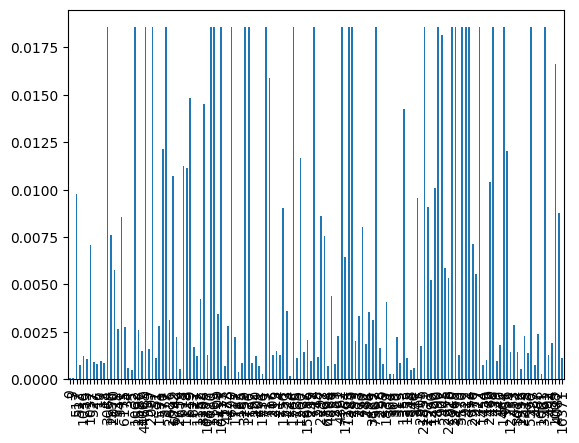

In [384]:
unique_ids_in_seq = list(set(inputs.input_ids))
scores = financial_mask_scores.loc[unique_ids_in_seq, "finance_score"]

prob_weights = scores.apply(np.exp).divide(scores.apply(np.exp).sum()) 
prob_weights.plot.bar()

In [385]:
most_likely = non_normalized_prob_weights.sort_values(ascending=False)
for id in most_likely.index.tolist()[:30]:
    print(tokenizer.convert_ids_to_tokens(id))

Ġcontents
oxley
Ġstockholders
Ġshares
Ġproxy
Ġregistrant
Ġaccounting
Ġstock
Ġ,,
Ġvalue
Ġaggregate
Ġaudit
Ġnonaffiliates
Ġattestation
Ġreporting
Ġsecurities
Ġfinancial
Ġmillion
Ġstockholder
yes
Ġitem
Ġdisclosures
Ġequity
Ġsarbanes
Ġoutstanding
Ġissuer
management
Ġpurchases
Ġ$
Ġfiled


In [417]:
mask_ids = np.array([prob_weights.loc[id] * n_rnd for id in inputs.input_ids])
(np.random.rand(len(mask_ids)) < mask_ids).sum()

53

# Reduce to unique ids first

In [216]:
scores = finance_and_wiki.loc[inputs.input_ids[1:-1], :].finance_score.values
scores

array([ 3.31076758e+00,  7.19278699e-01,  1.59875157e+00, -1.37184297e-01,
        1.78919365e+00,  3.90389567e-01,  1.48828096e+00, -8.82575559e-02,
        8.04565671e+00, -1.46103150e-01, -2.67195683e-02,  2.99924845e+00,
        4.36910951e-01,  1.27814154e+00,  1.99099724e+00,  4.59435906e-01,
        7.02438003e-01,  2.99924845e+00, -1.37184297e-01,  1.11023031e+00,
        1.28289037e+00,  5.89465596e-02, -3.59646582e-01,  1.49512417e-01,
        2.73594219e-01, -8.82575559e-02,  5.08187108e+00,  2.45206255e+00,
        1.13248330e+00,  2.73594219e-01,  4.80686691e-01, -8.82575559e-02,
        1.56916025e+00,  1.13698730e+00,  5.89465596e-02, -1.75700338e-01,
        4.49840515e-01,  8.01458079e-01,  9.23327384e-01,  1.65058852e+00,
        5.81961073e-01, -8.82575559e-02,  8.04565671e+00, -1.14106884e+00,
        1.99099724e+00,  4.59435906e-01,  1.95442207e+00,  8.01458079e-01,
        1.27814154e+00, -8.53824354e-01,  3.36200317e-01, -1.46103150e-01,
       -2.67195683e-02,  

In [217]:
prob_to_distribute = np.sum(inputs.attention_mask) * 0.15
prop_scores = np.exp(scores) / np.sum(np.exp(scores))
most_likely = np.flip(np.argsort(prop_scores * prob_to_distribute))
most_likely

array([210,   8, 122,  42, 104,  72, 187, 185, 161, 137, 131, 157, 191,
       127, 231,  84,  26, 190, 136, 160, 228, 227, 141, 193, 165,  64,
         0, 114, 186, 184, 130, 126, 156,  11,  17,  57, 221,  58, 196,
       147, 201, 171, 180,  27, 239,  75, 197, 194, 172, 202, 142, 166,
       148,  54,  88, 170,  14, 106,  44,  80,  79,  46, 229,  68,   4,
       118, 206, 218, 223, 219, 101,  39,  66, 204,   2, 116,  32,  94,
       200, 146, 195,   6,  70, 120, 188, 134, 108,  78, 230, 208, 198,
        20, 225, 144,  48,  13, 164,  95,  33, 181,  28, 240,  19, 233,
        83,  74, 226,  38, 100,  86, 175,  99,  56,  47, 111,  37,  61,
       115,   1,  65, 152,  82,  16, 213,  77, 102,  40,  30,  92, 107,
        45, 214, 232,  85,  81,  15,  55, 220,  98,  36,  59,  12,   5,
       119,  69, 207, 215, 168,  50, 109, 192, 140, 112, 237, 153,  29,
       178,  87,  24, 158, 162, 167,  62, 236,  23, 217,  96, 234,  21,
        34, 135,  90, 177, 189, 222,  53, 129, 145, 199, 211,  7

In [220]:
most_likely

array([210,   8, 122,  42, 104,  72, 187, 185, 161, 137, 131, 157, 191,
       127, 231,  84,  26, 190, 136, 160, 228, 227, 141, 193, 165,  64,
         0, 114, 186, 184, 130, 126, 156,  11,  17,  57, 221,  58, 196,
       147, 201, 171, 180,  27, 239,  75, 197, 194, 172, 202, 142, 166,
       148,  54,  88, 170,  14, 106,  44,  80,  79,  46, 229,  68,   4,
       118, 206, 218, 223, 219, 101,  39,  66, 204,   2, 116,  32,  94,
       200, 146, 195,   6,  70, 120, 188, 134, 108,  78, 230, 208, 198,
        20, 225, 144,  48,  13, 164,  95,  33, 181,  28, 240,  19, 233,
        83,  74, 226,  38, 100,  86, 175,  99,  56,  47, 111,  37,  61,
       115,   1,  65, 152,  82,  16, 213,  77, 102,  40,  30,  92, 107,
        45, 214, 232,  85,  81,  15,  55, 220,  98,  36,  59,  12,   5,
       119,  69, 207, 215, 168,  50, 109, 192, 140, 112, 237, 153,  29,
       178,  87,  24, 158, 162, 167,  62, 236,  23, 217,  96, 234,  21,
        34, 135,  90, 177, 189, 222,  53, 129, 145, 199, 211,  7

In [219]:
for id in most_likely:
    print(inputs.input_ids[id])
    print(tokenizer.convert_ids_to_tokens(inputs.input_ids[id]))

185
Ġthe
185
Ġthe
185
Ġthe
185
Ġthe
185
Ġthe
185
Ġthe
3622
Ġaccelerated
3622
Ġaccelerated
7078
accelerated
7078
accelerated
3622
Ġaccelerated
3622
Ġaccelerated
7078
accelerated
3622
Ġaccelerated
1590
Ġprovided
4765
Ġsubmitted
185
Ġthe
17
-
17
-
444
Ġ"
422
Ġfinancial
5232
Ġrevised
3844
Ġsmaller
3844
Ġsmaller
13812
smaller
18
.
0
<s>
848
).
3784
Ġfiler
11361
large
199
Ġan
1879
Ġlarge
11361
large
527
Ġhas
281
Ġbe
580
Ġsuch
237
Ġfor
4006
Ġfiling
4970
Ġemerging
4970
Ġemerging
4970
Ġemerging
14582
emerging
185
Ġthe
747
Ġsecurities
185
Ġthe
4765
Ġsubmitted
1196
Ġgrowth
1062
Ġreporting
1196
Ġgrowth
1196
Ġgrowth
1062
Ġreporting
1062
Ġreporting
1196
Ġgrowth
667
Ġbeen
200
Ġof
444
Ġ"
2280
Ġreports
309
Ġwas
309
Ġwas
2494
Ġfile
1179
Ġdata
213
Ġto
890
Ġaccounting
299
Ġby
299
Ġby
299
Ġby
299
Ġby
3780
Ġextended
287
Ġwith
3328
Ġtransition
5543
Ġshorter
5543
Ġshorter
494
Ġno
16
,
494
Ġno
494
Ġno
185
Ġthe
185
Ġthe
199
Ġan
199
Ġan
345
Ġcompany
475
Ġmark
475
Ġmark
475
Ġmark
3784
Ġfiler
177
Ġa
213
Ġto
7099
Ġ

# Open issues

* how to handle proportinal probability adjustment to guarantee that 0 <= masking prob <= 1
* what to do with same token at different position